In [3]:
from os import listdir
from os.path import isfile, join

mypath = './example_En_docs/'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

total_docs = []
for file in onlyfiles:
    file_path = mypath+file
    with open(file_path, 'r', encoding='utf8') as f:
        content = f.read()
    total_docs.append(content)

In [4]:
cleaned_total_docs = [doc.replace('\n', ' ') for doc in total_docs]
DOCS_NUM = len(cleaned_total_docs)

In [5]:
import preprocessing # import a python file for English text preprocessing

In [6]:
stopwords = ['be', 'today', 'yesterday', 'new', 'york', 'time']

In [7]:
docs = [preprocessing.En_processing(doc, stopwords) for doc in cleaned_total_docs] # (text, list of noun words)

In [8]:
total_docs_nouns = []
docs_nouns = []
for doc, words in docs:
    total_docs_nouns.extend(words)
    docs_nouns.append(words)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer # frequency based DTM
from sklearn.feature_extraction.text import TfidfVectorizer # tf-idf based DTM

In [10]:
def tf_extractor(corpus): 
    # returns a frequency-based DTM
    vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
    # min_df: minimum document frequency threshold
         # if min_df = 1 -> 최소 적어도 하나의 문서에서 사용된 단어들은 모두 포함
    # ngram_range=(1,1) -> unigram 만 포함
    # ngram_range=(1,3) -> unigram, bi-gram, tri-gram 까지 고려
    features = vectorizer.fit_transform(corpus) # transform texts to a frequency matrix
    return vectorizer, features  

In [11]:
def tfidf_extractor(corpus):
    # returns a tf-idf based DTM
    vectorizer = TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=(1,1))
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [12]:
documents_filtered = []
for doc in docs_nouns:
    document_filtered =''
    for word in doc:
        document_filtered = document_filtered+' '+word
    documents_filtered.append(document_filtered) # list of strings
# 불필요한 단어들을 제거하고 난후 DTM로 변환하기 위해 다시 list of strings의 형태로 변환

In [13]:
vectorizer, doc_term_mat_tfidf = tfidf_extractor(documents_filtered) # TFIDF matrix로 변환

In [14]:
import numpy as np

In [15]:
tfidf_dense = doc_term_mat_tfidf.todense()

In [16]:
tfidf_dense

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.04711425, 0.0409108 , 0.04711425, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [17]:
DTM_TFIDF = np.array(tfidf_dense)

In [18]:
DTM_TFIDF

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04711425, 0.0409108 , 0.04711425, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
from sklearn.cluster import AgglomerativeClustering

In [20]:
cluster_idf = AgglomerativeClustering(linkage='single', affinity='cosine', n_clusters=5).fit(DTM_TFIDF)

In [21]:
cluster_idf.labels_

array([0, 0, 0, 2, 2, 4, 4, 4, 1, 1, 1, 1, 3, 3, 3], dtype=int64)

In [22]:
cluster_idf1 = AgglomerativeClustering(linkage='single', affinity='cosine', n_clusters=4).fit(tfidf_dense)

In [23]:
cluster_idf1.labels_

array([2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 3, 3, 3], dtype=int64)

In [24]:
import sklearn

In [25]:
sklearn.__version__

'0.20.0'

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
cosine_similarity(tfidf_dense[0], tfidf_dense[1])

array([[0.41003831]])

In [28]:
cosine_similarity(DTM_TFIDF[0].reshape(1,-1), DTM_TFIDF[1].reshape(1,-1))

array([[0.41003831]])

In [29]:
cosine_similarity(DTM_TFIDF[4].reshape(1,-1), DTM_TFIDF[5].reshape(1,-1))

array([[0.17339087]])

In [30]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity # cosine similarity 계산하기
import itertools

In [31]:
clusters = []
g = nx.Graph()
g.add_nodes_from(list(range(DOCS_NUM)))
for pair in list(itertools.combinations(range(DOCS_NUM), 2)):
    similarity = cosine_similarity(DTM_TFIDF[pair[0]].reshape(1,-1), DTM_TFIDF[pair[1]].reshape(1,-1))[0][0]

    if similarity>0.2: # 문서간의 유사도 기준을 0.35로 한 경우
        g.add_edge(pair[0], pair[1], weight=similarity)

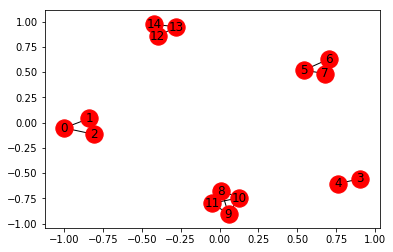

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw_networkx(g)
plt.show()

In [33]:
list(nx.connected_components(g))

[{0, 1, 2}, {3, 4}, {5, 6, 7}, {8, 9, 10, 11}, {12, 13, 14}]